In [21]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import re
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try without goalies
#data = data[(data['Position'] != 'G')]
data = data[(data['Position'] == 'C') | (data['Position'] == 'LW') | (data['Position'] == 'RW')]

# encode position
# TODO: we should keep the positions for when we do clustering
position = preprocessing.LabelEncoder()
position.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: position.transform([x])[0])

team = preprocessing.LabelEncoder()
team.fit(data['Team'].unique())
data['Team'] = data['Team'].apply(lambda x: team.transform([x])[0])


data.head()

,Year,Position,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2022,1,1,15,1.0,Juraj Slafkovsky,Slafkovsky has all the assets you're looking f...,Slafkovsky is one of the draft's most tantaliz...,Slafkovsky can be a menace at the NHL level. H...,The potential of what Slafkovsky can be as he ...,Slafkovsky is one of the largest players in th...,Nothing brought out Juraj Slafkovsky's draft y...,Slafkovsky dominated the international scene t...,Juraj Slafkovsky drives offense from the wing....
1,2022,0,4,23,2.0,Shane Wright,Wright is a very well-rounded center who has n...,Still my top prospect in this class (though no...,The complicated and essential question to answ...,With high-end hockey sense highlighted by his ...,The top player from the class held this positi...,In a draft year shaped by substantial depth ra...,Wright has been on the radar of scouts for a l...,Shane Wright is an elite two-way center with i...
3,2022,0,3,1,3.0,Logan Cooley,Cooley is a dynamic player. When he has the pu...,"Cooley is a beautiful, flowing skater capable ...",Logan Cooley is for sure one of the more well-...,"Over the last several months, I have constantl...","A highly creative, speed-driven pivot who brin...",You won't find a more singularly-gifted puckha...,"A small, speedy center, Cooley dominated the U...",Juraj Slafkovsky drives offense from the wing....
5,2022,0,9,3,6.0,Matthew Savoie,Savoie is a very talented scorer. He stands ou...,There isn't a player in this draft class whose...,Matthew Savoie has star potential at the NHL l...,"A top-10 scorer in the WHL this season, Savoie...",A point-producing machine in the WHL this past...,Few players in the 2022 NHL Draft have spent m...,I've been high on Savoie all season and my imp...,Matthew Savoie is an extremely intelligent pla...
6,2022,2,17,17,7.0,Joakim Kemell,Kemell is a well-rounded winger who has almost...,After exploding out of the gate to lead Liiga ...,"Second line winger, who can be a threat on a N...",A high-scoring winger who put up impressive nu...,A high-end finisher with a top-notch one-timer...,Nothing about Joakim Kemell's profile coming i...,Kemell burst onto the scene this season in Fin...,Joakim Kemell is a talented forward who shot u...


In [23]:
corpus, labels, draft_position, player_position, player_name, team = [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]


# remove references to leagues, teams, and nationalities
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna", "frolunda",
                "slovakia"]


for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    scouting_report = row[report]
    scouting_report = scouting_report.lower()
    # remove player name from report
    names = row['Name'].lower().split(' ')
    for name in names:
      scouting_report = scouting_report.replace(name + "'s", '')
      scouting_report = scouting_report.replace(name, '')
    
    scouting_report = scouting_report.replace('\n', ' ')
    scouting_report = scouting_report.replace('\r', '')

    # remove hockey specific stop words
    # TODO: there is an issue where a hockey word includes punctuation, it does not get removed
    # for instance: "usntdp," will not get removed
    scouting_report = scouting_report.split()
    scouting_report = [word for word in scouting_report if (word.replace("'s", "").replace(",", "").replace(".", "") not in hockey_words)]
    # join back on spaces
    scouting_report = ' '.join(scouting_report)

    text = text + " " + scouting_report

  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  team.append(row['Team'])
# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 239
length of labels: 239
length of draft_position: 239
length of player_position: 239
corpus first 5: [" has all the assets you're looking for in a top nhl forward. he's a 6-foot-4 winger who can beat opponents with speed and skill. he possesses outstanding puck skills and can put pucks through legs and sticks at a very high rate. can use finesse, or power and quickness to get around defenders. can also set up and finish plays well. physically, he won't run over guys but his compete is good enough. he projects as a top-line winger with the potential to pop and become a true star in the nhl. is one of the draft's most tantalizing prospects, with a skill-size combo that scouts and coaches clamour for and he has already demonstrated against pro competition domestically and, more notably, internationally. it has been a big year for him. nine points in five games and a historic silver medal for the slovaks at the hlinka gretzky cup. an olympic bronze medal as the tourname

In [24]:
# attempting to vectorize using bert embeddings
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')
X = pd.DataFrame(list(zip(team, player_name, draft_position, player_position, corpus)), columns=['team', 'player_name', 'draft_position', 'player_position', 'report'])
X['embeddings'] = 0
X['embeddings'] = X['embeddings'].astype('float64')
Y = labels

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

#print(f"Boqvist Report: {X_train[X_train['player_name'] == 'Jesper Boqvist']['report'].values[0]}")
sentences = X_train['report'].values
players = X_train['player_name'].values
#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:10]:
    print("{} \t {} \t {:.4f}".format(players[i], players[j], cos_sim[i][j]))

Top-5 most similar pairs:
Frank Nazar 	 Noah Ostlund 	 0.9528
David Goyette 	 Philip Tomasino 	 0.9514
David Goyette 	 Jiri Kulich 	 0.9509
Adrien Kempe 	 Jiri Kulich 	 0.9503
Brendan Perlini 	 Adrien Kempe 	 0.9482
Frank Nazar 	 Jake Virtanen 	 0.9476
Noah Ostlund 	 Paul Bittner 	 0.9468
Connor McMichael 	 Chaz Lucius 	 0.9456
Jake Debrusk 	 Sebastian Aho 	 0.9454
Nikita Chibrikov 	 Rasmus Kupari 	 0.9448


In [25]:
VECTOR_SIZE = 100
from sklearn.preprocessing import Normalizer

print(f"pre-normalized embeddings: {embeddings[0].mean(axis=0)}")
transformer = Normalizer().fit(embeddings)
embeddings = transformer.transform(embeddings)
print(f"post-normalized embeddings: {embeddings[0].mean(axis=0)}")
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv.index_to_key]
    if len(words_vecs) == 0:
        return np.zeros(VECTOR_SIZE)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

converted_embeddings = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
X_train['embeddings'] = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
#X_test['report'] = np.array([vectorize(sentence) for sentence in X_test['report'].values])

X_train['embeddings'].head(1)

pre-normalized embeddings: -0.00013565596600528806
post-normalized embeddings: -0.00013565596600528806


113   -0.000136
Name: embeddings, dtype: float64

Exploring Kmeans now for unsupervised learning

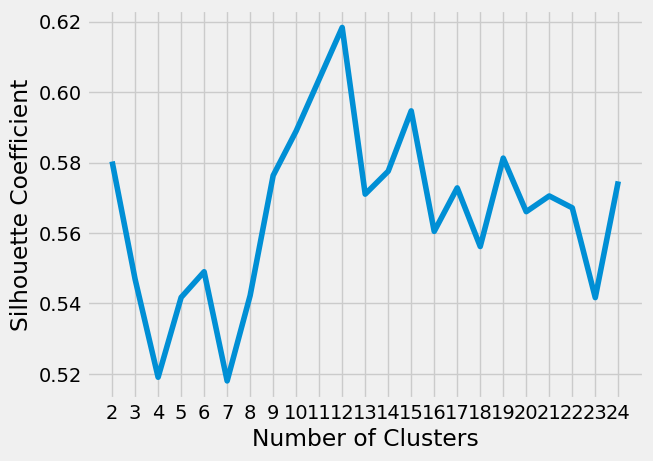

In [26]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []

  formated_data = np.array(data).reshape(-1, 1)

  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

plot_silhouette_scores(X_train['embeddings'], 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [27]:
SELECTED_CLUSTERS = 12

In [28]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
labels = kmeans.fit_predict(np.array(X_train['embeddings']).reshape(-1, 1))

X_train['label'] = labels

In [29]:
# show the top words for each cluster that was created
def get_top_features_cluster(X_train):
    data = X_train[X_train['label'] == 14]
    for index, row in data.iterrows():
        print("")
        print("player name: {}", row['player_name'])
        print(row['report'])
        
    

get_top_features_cluster(X_train)

In [30]:
import plotly.express as px

print(X_train.columns)
print(X_train.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X_train, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['team', 'player_name', 'draft_position', 'player_position', 'report',
       'embeddings', 'label'],
      dtype='object')
     team        player_name  draft_position  player_position  \
113    18  Oliver Whahlstrom              11                2   
148    25        Klim Kostin              31                1   
191    12      Lawson Crouse              11                1   
212    11     Leon Draisaitl               3                0   
133     3  Casey Mittelstadt               8                0   

                                                report  embeddings  label  
113   wahlstrom has been one of the best snipers to...   -0.000136      0  
148   ice time was very limited playing versus men ...   -0.000161      5  
191   is a player with fantastic physical gifts, an...   -0.000153      5  
212   is one of the best -- if not the best -- nhl ...   -0.000098     11  
133   has been a highly touted player for a few yea...   -0.000098     11  


c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



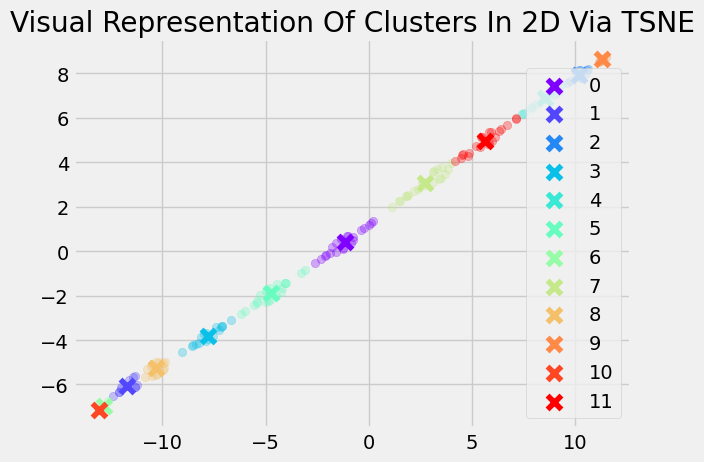

In [31]:
tsne = TSNE(n_components=2, learning_rate=200)
data = X_train['embeddings'].values
vis_dims2 = tsne.fit_transform(data.reshape(-1, 1))

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X_train.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X_train.label == category]
    ys = np.array(y)[X_train.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()

In [12]:

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_train[['player_position', 'draft_position', 'label']], X_train['team'], test_size=0.33)
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

print(f"Linear Regression Score: {lr.score(X_test_lr, y_test_lr)}")



Linear Regression Score: -0.11381445922795375
